<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/text_and_sequences/gru_conv1d_weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Weather Forecast with GRU on top of a Conv1D

Knowing the potential of feature extraction from the a convolutional layer, we're reducing the representation of the sequences and pushing it into a GRU layer and see how well it performs. This approach also makes it cheaper in terms of learning speed.

##Getting the Dataset

In [2]:
# First we set up the data folder
!mkdir jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip -d jena_climate
!rm  jena_climate_2009_2016.csv.zip 

--2021-01-23 01:18:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  17.3MB/s    in 0.7s    

2021-01-23 01:18:45 (17.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate/jena_climate_2009_2016.csv  
  inflating: jena_climate/__MACOSX/._jena_climate_2009_2016.csv  


Now we process the input file which contains all the data.

In [3]:
import os

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(f'Header: {header}')
print(f'No. Lines: {len(lines)}')

Header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
No. Lines: 420451


Moving from primitive array to NumPy array

In [4]:
import numpy as np

# Dimenssion: Elements, Features
float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

###Ploting the temperature in timeseries.

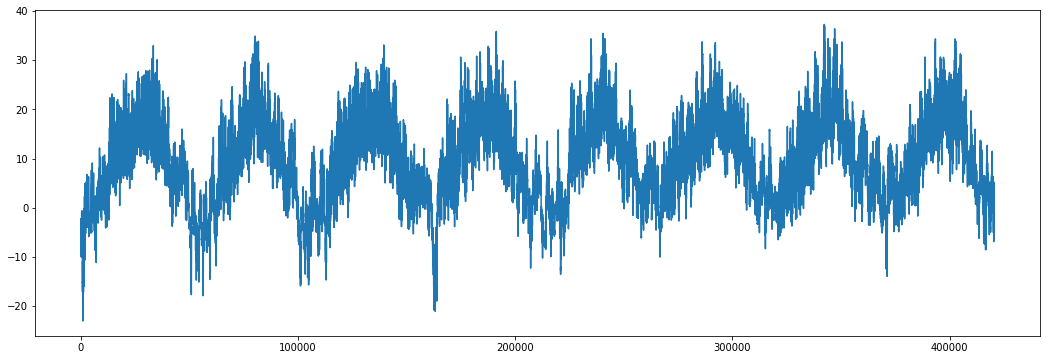

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.figure(figsize=(18, 6))
plt.plot(range(len(temp)), temp)

The dataset is composed by a 10-minutes frame metrics, meaning that per day there's `144` measures. To figure the first ten days we have to plot the first `1440` entries.

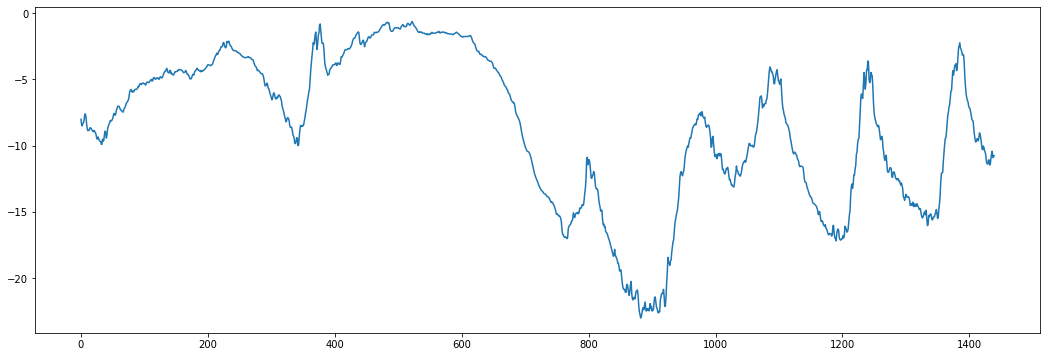

In [6]:
plt.figure(figsize=(18, 6))
plt.plot(range(1440), temp[:1440])

##Preparing the Data

We're shaping the problem as follow:

Given a data going back as `lookback` timesteps (knowing that a timestep is 10 mint), and sampling every `steps` timesteps, we're predicting the temperature in `delay` timestep.

That said, some sample values are:

- `lookback = 720` -  Training back 5 days.
- `steps = 6` - Looking a 1 point per hour: 60/10 = 6.
- `delay = 144` -  The target is 24 hrs: 6 * 24 = 144.

We also need to shape the `float_data` into something that the neural network can digest, and also we need to scale down everything.

We're using the first 200,000 entries for training, so we're taking its mean and standard deviation.

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now we're setting a `generator` that yields a tuple of input data shaped as `(samples, targets)`.

In [8]:
def generator(data,lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1

  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      # Defines the data slide indices
      idx = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[idx]
      targets[j] = data[rows[j] + delay][1]
    
    yield samples, targets

Now we define different generators for the splits we need

In [9]:
lookback = 720
# The step is 3, not 6 as seen in other examples
step = 3
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200_000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200_001,
    max_index=300_000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300_001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
500/500 [==============================] - 96s 187ms/step - loss: 0.3633 - val_loss: 0.2794
Epoch 2/20
500/500 [==============================] - 91s 182ms/step - loss: 0.3043 - val_loss: 0.2808
Epoch 3/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2894 - val_loss: 0.2866
Epoch 4/20
500/500 [==============================] - 99s 198ms/step - loss: 0.2770 - val_loss: 0.2786
Epoch 5/20
500/500 [==============================] - 93s 187ms/step - loss: 0.2690 - val_loss: 0.2798
Epoch 6/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2634 - val_loss: 0.2828
Epoch 7/20
500/500 [==============================] - 93s 185ms/step - loss: 0.2583 - val_loss: 0.2868
Epoch 8/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2515 - val_loss: 0.2825
Epoch 9/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2474 - val_loss: 0.2870
Epoch 10/20
500/500 [==============================] - 92s 184ms/step - l

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

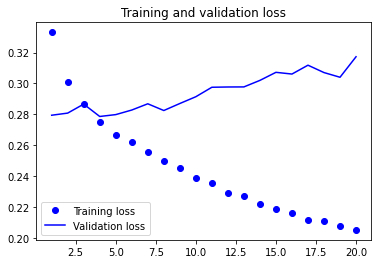

In [13]:
plot_history(history)

Perhaps this seems to overfit, the result isn't bad at all and really fast training and not so far from a soley RNN implementation. 